# Data Cleaning, EDA & Feature Engineering

We choose trip and weather data from 2024 and May/Oct 2025 because we use 2024 as the training set, May 2025 as the validation set, and October 2025 as the test set, so we can tune and evaluate the model while using 2024-based baselines. In addition, May and October show moderate demand and are more representative months for validation and testing. The split is roughly 83:9:8 across train/validation/test, which is reasonable.

In [1]:
import requests, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

## BIXI 2024 Trip History Dataset

In [2]:
# Data source: https://bixi.com/en/open-data/
trip_24_df =  pd.read_csv("bixi_trip_2024.csv")   
trip_24_df.head()

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS
0,Métro Champ-de-Mars (Viger / Sanguinet),Ville-Marie,45.510253,-73.556777,St-Antoine / Jean-Paul Riopelle,Ville-Marie,45.502940,-73.560640,1704230756167,1.704231e+12
1,Métro Place-d'Armes (Viger / St-Urbain),Ville-Marie,45.506314,-73.559671,de Maisonneuve / Aylmer (est),Ville-Marie,45.505386,-73.570432,1704232888826,1.704233e+12
2,Émile-Duployé / Sherbrooke,Le Plateau-Mont-Royal,45.527195,-73.564526,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704238154678,1.704239e+12
3,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Roy / St-André,Le Plateau-Mont-Royal,45.521564,-73.570367,1704232695740,1.704233e+12
4,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.531027,-73.598623,Parc Molson (d'Iberville / Beaubien),Rosemont - La Petite-Patrie,45.549022,-73.591982,1704243796167,1.704244e+12


In [3]:
trip_25_df =  pd.read_csv("bixi_trip_2025_partial.csv")   
trip_25_df.head()

,STARTSTATIONNAME,STARTSTATIONARRONDISSEMENT,STARTSTATIONLATITUDE,STARTSTATIONLONGITUDE,ENDSTATIONNAME,ENDSTATIONARRONDISSEMENT,ENDSTATIONLATITUDE,ENDSTATIONLONGITUDE,STARTTIMEMS,ENDTIMEMS
0,Fullum / Marie-Anne,Le Plateau-Mont-Royal,45.536505,-73.568039,Boyer / du Mont-Royal,Le Plateau-Mont-Royal,45.527432,-73.579917,1745255625940,1.745256e+12
1,de Normanville / Everett,Villeray—Saint-Michel—Parc-Extension,45.545433,-73.614385,Marquette / du Mont-Royal (sud),Le Plateau-Mont-Royal,45.532077,-73.575143,1745242787194,1.745244e+12
2,Prince-Arthur / Ste-Famille,Le Plateau-Mont-Royal,45.511670,-73.574635,Duluth / St-Denis,Le Plateau-Mont-Royal,45.520628,-73.575949,1745244099726,1.745244e+12
3,du Canal / McLaughlin,Lachine,45.429692,-73.669488,St-Patrick / Thomas-Keefer,Le Sud-Ouest,45.478012,-73.574273,1745254311560,1.745257e+12
4,de l'Hôtel-de-Ville / Villeneuve,Le Plateau-Mont-Royal,45.523481,-73.587328,Marmier / St-Denis,Rosemont - La Petite-Patrie,45.530805,-73.598396,1745255560449,1.745256e+12


In [4]:
trip_df = pd.concat([trip_24_df, trip_25_df], ignore_index=True)
trip_df = trip_df.drop(columns=["STARTSTATIONARRONDISSEMENT", "ENDSTATIONARRONDISSEMENT"])
trip_df.shape

(26688462, 8)

In [5]:
# Standardize column names
trip_df.columns = (trip_df.columns              
              .str.normalize("NFKD")                    
              .str.encode("ascii","ignore").str.decode("ascii")
              .str.strip()
              .str.lower()
              .str.replace(r"[^a-z0-9]+", "_", regex=True)  
              .str.replace(r"_+", "_", regex=True)          
              .str.strip("_"))

trip_df.head()

,startstationname,startstationlatitude,startstationlongitude,endstationname,endstationlatitude,endstationlongitude,starttimems,endtimems
0,Métro Champ-de-Mars (Viger / Sanguinet),45.510253,-73.556777,St-Antoine / Jean-Paul Riopelle,45.502940,-73.560640,1704230756167,1.704231e+12
1,Métro Place-d'Armes (Viger / St-Urbain),45.506314,-73.559671,de Maisonneuve / Aylmer (est),45.505386,-73.570432,1704232888826,1.704233e+12
2,Émile-Duployé / Sherbrooke,45.527195,-73.564526,Parc Molson (d'Iberville / Beaubien),45.549022,-73.591982,1704238154678,1.704239e+12
3,Marmier / St-Denis,45.531027,-73.598623,Roy / St-André,45.521564,-73.570367,1704232695740,1.704233e+12
4,Marmier / St-Denis,45.531027,-73.598623,Parc Molson (d'Iberville / Beaubien),45.549022,-73.591982,1704243796167,1.704244e+12


In [6]:
# Check for null values
trip_df.isnull().sum()

startstationname           1243
startstationlatitude       1243
startstationlongitude      1243
endstationname           120461
endstationlatitude       120461
endstationlongitude      120461
starttimems                   0
endtimems                119144
dtype: int64

In [7]:
# Drop null values
trip_df= trip_df.dropna()

In [8]:
# Check data types 
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26566799 entries, 0 to 26688461
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   startstationname       object 
 1   startstationlatitude   float64
 2   startstationlongitude  float64
 3   endstationname         object 
 4   endstationlatitude     float64
 5   endstationlongitude    float64
 6   starttimems            int64  
 7   endtimems              float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.8+ GB


In [9]:
# Convert startimems and endtimems to datetime
trip_df["starttime"] = (
    pd.to_datetime(trip_df["starttimems"], unit="ms", utc=True)
      .dt.floor("s")                         
      .dt.tz_convert("America/Toronto")
      .dt.tz_localize(None)        
)

trip_df["endtime"] = (
    pd.to_datetime(trip_df["endtimems"], unit="ms", utc=True)
      .dt.floor("s")                           
      .dt.tz_convert("America/Toronto")
      .dt.tz_localize(None)       
)

trip_df = trip_df.drop(columns=["starttimems", "endtimems"]) # Drop initial unix time columns

print(trip_df["starttime"].max(), trip_df["endtime"].max())

2025-10-31 23:59:46 2025-11-12 06:34:36


In [10]:
# Keep trips where both start time and end time are in 2024, or in May/Oct 2025
clean_trip_df = trip_df[
    ((trip_df["starttime"].dt.year == 2024) &
        (trip_df["endtime"].dt.year == 2024))
    |
    ((trip_df["starttime"].dt.year == 2025) &
        (trip_df["starttime"].dt.month.isin([5, 10])) &
        (trip_df["endtime"].dt.year == 2025) &
        (trip_df["endtime"].dt.month.isin([5, 10])))].copy()

In [11]:
# Find the duration of each trip
clean_trip_df["trip_duration"] = clean_trip_df["endtime"] - clean_trip_df["starttime"]

# Convert the trip_duration in minutes
td = pd.to_timedelta(clean_trip_df["trip_duration"], errors="coerce")
clean_trip_df["trip_duration_min_round"] = (td.dt.total_seconds() / 60).round(2)

# Descriptive statistic for trip_duration_min_round
with pd.option_context("display.float_format", "{:,.2f}".format):
    print(clean_trip_df["trip_duration_min_round"].describe())

count   16,555,044.00
mean            16.39
std            290.11
min            -57.25
25%              5.93
50%             10.27
75%             17.48
max        255,388.92
Name: trip_duration_min_round, dtype: float64


In [12]:
# There are outliers below 0 and extremely large values; compute the 99th and 99.5th percentiles to help set a threshold
p95 = clean_trip_df["trip_duration_min_round"].quantile(0.95)
p99 = clean_trip_df["trip_duration_min_round"].quantile(0.99)
print(p95,p99)

35.27 59.93


In [13]:
# Based on the 99th percentile, we use 0–60 minutes as the acceptable range
clean_trip_df = clean_trip_df[(clean_trip_df["trip_duration_min_round"] > 0) & (clean_trip_df["trip_duration_min_round"] <= 60)].reset_index(drop=True)
clean_trip_df.shape

(16389593, 10)

In [14]:
# Select the top 400 stations based on total 2024 trip demand (starts + ends) and compute hourly demand for those stations
# Build long format
starts_all = (clean_trip_df[["startstationname", "starttime",
                             "startstationlatitude", "startstationlongitude"]]
              .rename(columns={"startstationname": "station",
                               "starttime": "datetime",
                               "startstationlatitude": "lat",
                               "startstationlongitude": "lon"}))

ends_all   = (clean_trip_df[["endstationname", "endtime",
                             "endstationlatitude", "endstationlongitude"]]
              .rename(columns={"endstationname": "station",
                               "endtime": "datetime",
                               "endstationlatitude": "lat",
                               "endstationlongitude": "lon"}))

long_df_all = pd.concat([starts_all, ends_all], ignore_index=True)
long_df_all["datetime"] = pd.to_datetime(long_df_all["datetime"]).dt.floor("h")

# Compute top 400 stations using only 2024 data
long_df_2024 = long_df_all[long_df_all["datetime"].dt.year == 2024]
top_400 = long_df_2024["station"].value_counts().head(400).index

# Filter ALL data by those top 400 stations
long_df_top = long_df_all[long_df_all["station"].isin(top_400)]

# Hourly demand output
station_demand = (long_df_top
                  .groupby(["station", "lat", "lon", "datetime"], as_index=False)
                  .size()
                  .rename(columns={"size": "total_demand"})
                  [["station", "lat", "lon", "datetime", "total_demand"]])

station_demand.head()

,station,lat,lon,datetime,total_demand
0,10e avenue / Masson,45.550377,-73.573734,2024-03-29 13:00:00,1
1,10e avenue / Masson,45.550377,-73.573734,2024-03-29 14:00:00,2
2,10e avenue / Masson,45.550377,-73.573734,2024-03-29 15:00:00,4
3,10e avenue / Masson,45.550377,-73.573734,2024-03-29 16:00:00,3
4,10e avenue / Masson,45.550377,-73.573734,2024-03-29 17:00:00,6


In [15]:
# Add time features
station_demand["hour"] = station_demand["datetime"].dt.hour
station_demand["dow"] = station_demand["datetime"].dt.dayofweek + 1
station_demand["month"] = station_demand["datetime"].dt.month

# Quebec/Montreal public holidays 
holidays_2024 = [
    "2024-01-01",  # New Year"s Day
    "2024-03-29",  # Good Friday
    "2024-04-01",  # Easter Monday (public sector)
    "2024-05-20",  # National Patriots" Day
    "2024-06-24",  # Fête nationale du Québec
    "2024-07-01",  # Canada Day
    "2024-09-02",  # Labour Day
    "2024-10-14",  # Thanksgiving
    "2024-12-25",  # Christmas
    "2024-12-26",  # Boxing Day
]
holidays_2024 = pd.to_datetime(holidays_2024)
station_demand["is_holiday"] = (
    station_demand["datetime"].dt.date.isin(holidays_2024.date).astype(int)
)

station_demand.head()

,station,lat,lon,datetime,total_demand,hour,dow,month,is_holiday
0,10e avenue / Masson,45.550377,-73.573734,2024-03-29 13:00:00,1,13,5,3,1
1,10e avenue / Masson,45.550377,-73.573734,2024-03-29 14:00:00,2,14,5,3,1
2,10e avenue / Masson,45.550377,-73.573734,2024-03-29 15:00:00,4,15,5,3,1
3,10e avenue / Masson,45.550377,-73.573734,2024-03-29 16:00:00,3,16,5,3,1
4,10e avenue / Masson,45.550377,-73.573734,2024-03-29 17:00:00,6,17,5,3,1


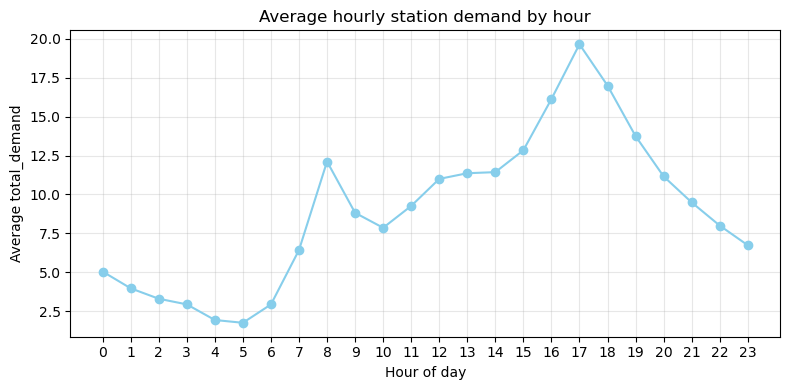

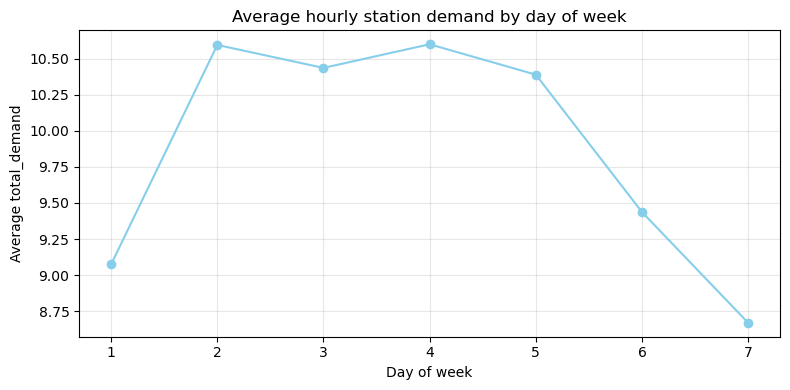

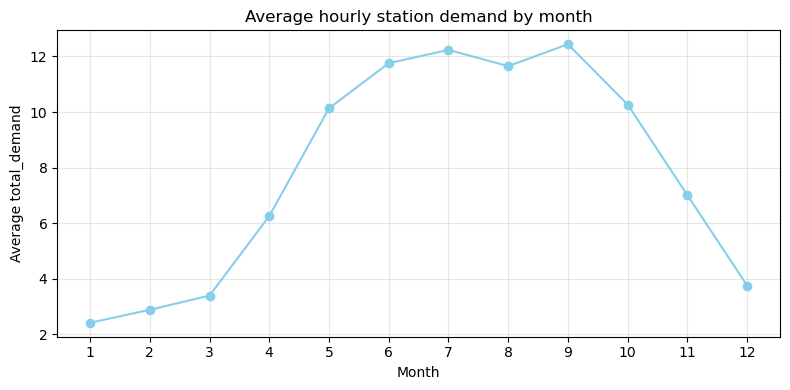

Average hourly station demand (Non-holiday): 9.9282
Average hourly station demand (Holiday): 7.9861


In [16]:
df = station_demand.copy()

# Average hourly station demand by hour
avg_by_hour = df.groupby("hour")["total_demand"].mean().sort_index()

plt.figure(figsize=(8, 4))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o", color="skyblue")
plt.title("Average hourly station demand by hour")
plt.xlabel("Hour of day")
plt.ylabel("Average total_demand")
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Average hourly station demand by day of week
avg_by_dow = df.groupby("dow")["total_demand"].mean().sort_index()

plt.figure(figsize=(8, 4))
plt.plot(avg_by_dow.index.astype(int), avg_by_dow.values, marker="o", color="skyblue")
plt.title("Average hourly station demand by day of week")
plt.xlabel("Day of week")
plt.ylabel("Average total_demand")
plt.xticks(avg_by_dow.index.astype(int))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Average hourly station demand by month
avg_by_month = df.groupby("month")["total_demand"].mean().sort_index()

plt.figure(figsize=(8, 4))
plt.plot(avg_by_month.index.astype(int), avg_by_month.values, marker="o", color="skyblue")
plt.title("Average hourly station demand by month")
plt.xlabel("Month")
plt.ylabel("Average total_demand")
plt.xticks(avg_by_month.index.astype(int))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print avg hourly station demand on holiday vs non-holiday
avg_by_holiday = df.groupby("is_holiday")["total_demand"].mean().sort_index()
non_holiday_avg = avg_by_holiday.get(0, float("nan"))
holiday_avg = avg_by_holiday.get(1, float("nan"))

print(f"Average hourly station demand (Non-holiday): {non_holiday_avg:.4f}")
print(f"Average hourly station demand (Holiday): {holiday_avg:.4f}")

**Interpretation:** **Hour:** Average hourly station demand shows a clear diurnal pattern, with a morning bump and a strong peak in the early evening.

**Day of week:** Demand is relatively stable across weekdays but drops noticeably on weekends.

**Month:** Demand is strongly seasonal, lowest in winter, rising sharply from spring and peaking in summer/early fall.

**Holiday:** Demand is lower on holidays than on non-holidays.

Adding station-hour, station–day-of-week, and station-month 2024 mean-demand baselines provides a valuable baseline signal for model training.

In [17]:
# Add station-hour, station–day-of-week, station-month 2024 mean demand baselines
# Use 2024 data to build baseline lookup tables
df_2024 = station_demand[station_demand["datetime"].dt.year == 2024].copy()

# 2024 mean demand by (station, hour / dow / month)
hour_mean_24 = df_2024.groupby(["station", "hour"])["total_demand"].mean()
dow_mean_24  = df_2024.groupby(["station", "dow"])["total_demand"].mean()
month_mean_24 = df_2024.groupby(["station", "month"])["total_demand"].mean()

# Assign baselines:
# For 2024 rows: the mean is computed from 2024 itself
# For 2025 rows: the value is taken from the matching 2024 mean
station_demand["station_hour_demand_24"] = station_demand.set_index(["station", "hour"]).index.map(hour_mean_24)
station_demand["station_dow_demand_24"]  = station_demand.set_index(["station", "dow"]).index.map(dow_mean_24)
station_demand["station_month_demand_24"] = station_demand.set_index(["station", "month"]).index.map(month_mean_24)

station_demand.isna().sum()

station                        0
lat                            0
lon                            0
datetime                       0
total_demand                   0
hour                           0
dow                            0
month                          0
is_holiday                     0
station_hour_demand_24         0
station_dow_demand_24          0
station_month_demand_24    12725
dtype: int64

In [18]:
# Fallback strategy for missing station-month baselines
station_mean_24 = df_2024.groupby(["station"])["total_demand"].mean()
global_mean_24 = df_2024["total_demand"].mean()

station_demand["station_month_demand_24"] = (
    station_demand["station_month_demand_24"]
      .fillna(station_demand["station"].map(station_mean_24))
      .fillna(global_mean_24)
)
station_demand.isna().sum()

station                    0
lat                        0
lon                        0
datetime                   0
total_demand               0
hour                       0
dow                        0
month                      0
is_holiday                 0
station_hour_demand_24     0
station_dow_demand_24      0
station_month_demand_24    0
dtype: int64

In [19]:
final_demand_df = station_demand.copy()
final_demand_df.head()

,station,lat,lon,datetime,total_demand,hour,dow,month,is_holiday,station_hour_demand_24,station_dow_demand_24,station_month_demand_24
0,10e avenue / Masson,45.550377,-73.573734,2024-03-29 13:00:00,1,13,5,3,1,16.960000,13.933962,2.378378
1,10e avenue / Masson,45.550377,-73.573734,2024-03-29 14:00:00,2,14,5,3,1,17.630058,13.933962,2.378378
2,10e avenue / Masson,45.550377,-73.573734,2024-03-29 15:00:00,4,15,5,3,1,19.473988,13.933962,2.378378
3,10e avenue / Masson,45.550377,-73.573734,2024-03-29 16:00:00,3,16,5,3,1,22.413793,13.933962,2.378378
4,10e avenue / Masson,45.550377,-73.573734,2024-03-29 17:00:00,6,17,5,3,1,24.752874,13.933962,2.378378


## MTL 2024 Weather Dataset

In [20]:
# Data source: https://montreal.weatherstats.ca/download.html (choose "Climate Hourly" option)
weather_df = pd.read_csv("mtl_weather_hourly.csv")
weather_df.head()

,date_time_local,unixtime,pressure_station,pressure_sea,wind_dir,wind_dir_10s,wind_speed,wind_gust,relative_humidity,dew_point,...,windchill,humidex,visibility,health_index,cloud_cover_4,cloud_cover_8,cloud_cover_10,solar_radiation,max_air_temp_pst1hr,min_air_temp_pst1hr
0,2025-12-25 13:00:00 EST,1766685600,101.22,101.69,N,0.0,20,30.0,57.0,-12.4,...,-12.0,NaN,24100.0,NaN,NaN,7.0,NaN,737.0,-4.7,-5.2
1,2025-12-25 12:00:00 EST,1766682000,101.13,101.59,NNW,34.0,29,40.0,57.0,-12.0,...,-13.0,NaN,24100.0,NaN,NaN,7.0,NaN,768.0,-4.2,-4.9
2,2025-12-25 11:00:00 EST,1766678400,101.09,101.55,NW,32.0,22,NaN,68.0,-9.5,...,-11.0,NaN,24100.0,NaN,NaN,8.0,NaN,690.0,-4.2,-4.8
3,2025-12-25 10:00:00 EST,1766674800,101.04,101.50,WNW,29.0,15,NaN,76.0,-8.4,...,-10.0,NaN,24100.0,NaN,NaN,8.0,NaN,306.0,-4.8,-5.0
4,2025-12-25 09:00:00 EST,1766671200,100.96,101.42,NW,31.0,15,NaN,79.0,-8.0,...,-10.0,NaN,24100.0,NaN,NaN,8.0,NaN,142.0,-4.7,-4.9


In [21]:
# Check dtypes
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17600 entries, 0 to 17599
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time_local      17600 non-null  object 
 1   unixtime             17600 non-null  int64  
 2   pressure_station     17600 non-null  float64
 3   pressure_sea         17600 non-null  float64
 4   wind_dir             17170 non-null  object 
 5   wind_dir_10s         17357 non-null  float64
 6   wind_speed           17600 non-null  int64  
 7   wind_gust            4248 non-null   float64
 8   relative_humidity    17599 non-null  float64
 9   dew_point            17599 non-null  float64
 10  temperature          17599 non-null  float64
 11  windchill            4431 non-null   float64
 12  humidex              3018 non-null   float64
 13  visibility           17577 non-null  float64
 14  health_index         0 non-null      float64
 15  cloud_cover_4        0 non-null     

In [22]:
# Convert unixtime to datetime and keep weather records in 2024, or in May/Oct 2025
weather_df["datetime"] = pd.to_datetime(weather_df["unixtime"], unit="s", utc=True).dt.tz_convert("America/Toronto").dt.tz_localize(None)

weather_df = weather_df[
    (weather_df["datetime"].dt.year == 2024) |
    ((weather_df["datetime"].dt.year == 2025) & (weather_df["datetime"].dt.month.isin([5, 10])))]

print(f'Date range: {weather_df["datetime"].min()} to {weather_df["datetime"].max()}')

Date range: 2024-01-01 00:00:00 to 2025-10-31 23:00:00


In [23]:
# Check for null values
weather_df.isnull().sum()

date_time_local            0
unixtime                   0
pressure_station           0
pressure_sea               0
wind_dir                 245
wind_dir_10s             132
wind_speed                 0
wind_gust               7883
relative_humidity          0
dew_point                  0
temperature                0
windchill               8362
humidex                 8550
visibility                20
health_index           10272
cloud_cover_4          10272
cloud_cover_8             49
cloud_cover_10         10272
solar_radiation         8386
max_air_temp_pst1hr        0
min_air_temp_pst1hr        0
datetime                   0
dtype: int64

In [24]:
"""
Based on the missing value profiles and each variable’s potential impact on BIXI trips, 
we select temperature, feels like temperature, wind speed, relative humidity, and visibility as the weather variables likely to affect ridership. 
And we treat conditions with high relative_humidity and low visibility as bad weather (e.g., rain).
"""
# Add feels like temperature
feels_like = np.where(
    weather_df["temperature"] <= 0,
    weather_df["windchill"],
    np.where(
        weather_df["temperature"] >= 20,
        weather_df["humidex"],
        weather_df["temperature"]
    )
)
weather_df["feels_like"] = np.where(pd.isna(feels_like), weather_df["temperature"], feels_like)

# Update the clean df
weather_column_keep = ["datetime", "temperature", "feels_like", "wind_speed", "relative_humidity", "visibility"]    
updated_weather_df = weather_df[weather_column_keep].copy()

updated_weather_df.head()

,datetime,temperature,feels_like,wind_speed,relative_humidity,visibility
1311,2025-10-31 23:00:00,7.4,7.4,31,86.0,19300.0
1312,2025-10-31 22:00:00,7.2,7.2,33,91.0,16100.0
1313,2025-10-31 21:00:00,5.8,5.8,28,95.0,9700.0
1314,2025-10-31 20:00:00,4.7,4.7,39,95.0,6400.0
1315,2025-10-31 19:00:00,4.6,4.6,39,94.0,6400.0


In [25]:
# Fill in the missing values of visibility. Since visibility usually changes smoothly over time, linear interpolation is a suitable method
# Interpolate visibility linearly based on time
updated_weather_df["visibility"] = updated_weather_df["visibility"].interpolate(method="linear")

# If still any missing (e.g. at start/end of data), fill with nearest valid value
updated_weather_df["visibility"] = (
    updated_weather_df["visibility"].bfill().ffill())

updated_weather_df.isna().sum()

datetime             0
temperature          0
feels_like           0
wind_speed           0
relative_humidity    0
visibility           0
dtype: int64

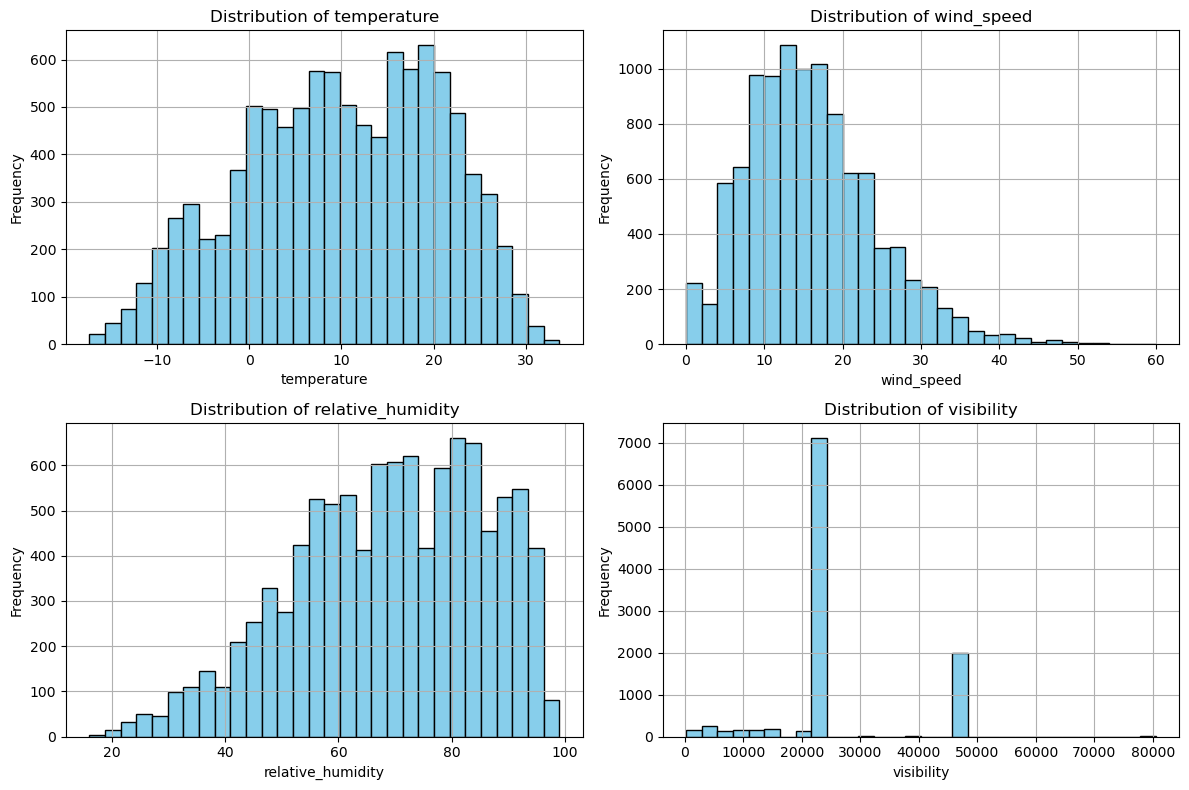

In [26]:
#  Distribution analysis of weather variables
weather_cols = ["temperature", "wind_speed", "relative_humidity", "visibility"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(weather_cols, 1):
    plt.subplot(2, 2, i)
    updated_weather_df[col].hist(bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


**Interpretation:** **Temperature** exhibits a clear seasonal pattern.

**Wind speed** is right-skewed, with most observations concentrated at moderate levels and a long tail of high-wind events. 

**Relative humidity** is generally high, with most values clustered between 50% and 90%.

**Visibility** values cluster around 24100 m, likely reflecting a reporting cap, while a small number near 50000 m are treated as outliers. To address this, based on meteorological conventions, we binned visibility into low (0–5000 m), medium (5000–15000 m), and high (>15000 m).

In [27]:
# Bin the visibility variable
# Define bins and labels
bins = [0, 5000, 15000, float("inf")] 
labels = ["low", "medium", "high"]

# Create a new categorical column for visibility levels
updated_weather_df["visibility_level"] = pd.cut(
    updated_weather_df["visibility"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False 
)

# Check the distribution
print(updated_weather_df["visibility_level"].value_counts())

visibility_level
high      9426
medium     452
low        394
Name: count, dtype: int64


C:\Users\cocos\AppData\Local\Temp\ipykernel_20568\254025443.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = updated_weather_df.groupby("visibility_level")["relative_humidity"].mean().reset_index()


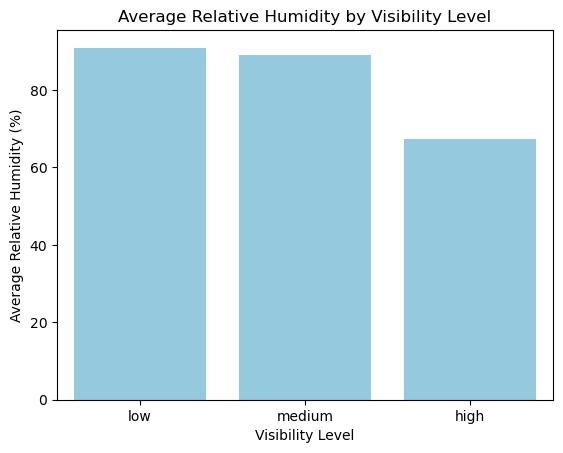

Spearman correlation: -0.39575371155294575


In [28]:
# Calculate the average relative humidity for each visibility category
grouped = updated_weather_df.groupby("visibility_level")["relative_humidity"].mean().reset_index()

# Visualize
sns.barplot(data=grouped, x="visibility_level", y="relative_humidity", color="skyblue")
plt.title("Average Relative Humidity by Visibility Level")
plt.xlabel("Visibility Level")
plt.ylabel("Average Relative Humidity (%)")
plt.show()

# Calculate the Spearman rank correlation between relative humidity and visibility level
corr = updated_weather_df["relative_humidity"].corr(updated_weather_df["visibility_level"].cat.codes, method="spearman")
print("Spearman correlation:", corr)

**Interpretation:**  As visibility decreases, average relative humidity rises sharply. The negative Spearman correlation (-0.4111) confirms that high humidity is typically associated with reduced visibility, indicating foggy or rainy weather. This supports creating a bad_weather variable combining humidity and visibility to capture adverse cycling conditions.

Based on meteorological conventions, we define bad_weather as cases where relative_humidity > 85% and visibility < 10000 m.

In [29]:
# Create a new variable bad_weather
updated_weather_df["bad_weather"] = (
    (updated_weather_df["relative_humidity"] > 85) &
    (updated_weather_df["visibility"] < 10000)
).astype(int)

# Delete relative_humidity and visibility
final_weather_df = updated_weather_df.drop(columns=["relative_humidity", "visibility", "visibility_level"])

# Check the distribution of bad vs. good weather
print(final_weather_df["bad_weather"].value_counts())

bad_weather
0    9713
1     559
Name: count, dtype: int64


In [30]:
final_weather_df.head()

,datetime,temperature,feels_like,wind_speed,bad_weather
1311,2025-10-31 23:00:00,7.4,7.4,31,0
1312,2025-10-31 22:00:00,7.2,7.2,33,0
1313,2025-10-31 21:00:00,5.8,5.8,28,1
1314,2025-10-31 20:00:00,4.7,4.7,39,1
1315,2025-10-31 19:00:00,4.6,4.6,39,1


## Merge datasets

In [31]:
# Merge station-level demand with weather features on datetime 
model_df = final_demand_df.merge(final_weather_df, on="datetime", how="left")
model_df.head()

,station,lat,lon,datetime,total_demand,hour,dow,month,is_holiday,station_hour_demand_24,station_dow_demand_24,station_month_demand_24,temperature,feels_like,wind_speed,bad_weather
0,10e avenue / Masson,45.550377,-73.573734,2024-03-29 13:00:00,1,13,5,3,1,16.960000,13.933962,2.378378,7.5,7.5,21,0
1,10e avenue / Masson,45.550377,-73.573734,2024-03-29 14:00:00,2,14,5,3,1,17.630058,13.933962,2.378378,7.9,7.9,32,0
2,10e avenue / Masson,45.550377,-73.573734,2024-03-29 15:00:00,4,15,5,3,1,19.473988,13.933962,2.378378,8.7,8.7,31,0
3,10e avenue / Masson,45.550377,-73.573734,2024-03-29 16:00:00,3,16,5,3,1,22.413793,13.933962,2.378378,9.0,9.0,33,0
4,10e avenue / Masson,45.550377,-73.573734,2024-03-29 17:00:00,6,17,5,3,1,24.752874,13.933962,2.378378,8.5,8.5,28,0


In [32]:
# Sort by datetime and reorder columns
model_df = model_df.sort_values("datetime").reset_index(drop=True)

cols = [
    "datetime", "station", "lat", "lon",
    "station_hour_demand_24", "station_dow_demand_24", "station_month_demand_24",
    "hour", "dow", "month", "is_holiday",
    "temperature", "feels_like", "wind_speed", "bad_weather",
    "total_demand"
]
model_df = model_df[cols]

# Export csv
model_df.to_csv("model_df.csv", index=False)
model_df.head()

,datetime,station,lat,lon,station_hour_demand_24,station_dow_demand_24,station_month_demand_24,hour,dow,month,is_holiday,temperature,feels_like,wind_speed,bad_weather,total_demand
0,2024-01-01,de la Commune / St-Sulpice,45.504242,-73.553469,7.038627,13.402640,1.803175,0,1,1,1,-4.8,-9.0,10,0,3
1,2024-01-01,Complexe Desjardins (St-Urbain / René-Lévesque),45.507885,-73.563151,5.048780,9.809725,2.188295,0,1,1,1,-4.8,-9.0,10,0,5
2,2024-01-01,de la Montagne / Notre-Dame,45.492913,-73.564688,5.214286,11.120758,1.937870,0,1,1,1,-4.8,-9.0,10,0,1
3,2024-01-01,Métro Sauvé (Berri / Sauvé),45.550692,-73.656367,2.913706,5.806045,1.418994,0,1,1,1,-4.8,-9.0,10,0,1
4,2024-01-01,Parc Molson (d'Iberville / Beaubien),45.549022,-73.591982,2.906780,4.621802,2.442748,0,1,1,1,-4.8,-9.0,10,0,2
